In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# General Libraries 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Scikit-Learn Libraries
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Keras Libraries 
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model
from keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam

# Interactive Widgets
from ipywidgets import interact
from IPython.display import display

# Load Data
trainDF = pd.read_csv("./data/titanic/train.csv")
testDF = pd.read_csv("./data/titanic/test.csv")

C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Our prepprocessing function which is applied to every row of the target dataframe. 
def preprocessRow(row):
    # Process Categorical Variables - One-Hot-Encoding
    sex      = [0,0]
    embarked = [0,0,0]
    pclass   = [0,0,0]
    
    if row["Sex"] == "male":
        sex = [0,1]
    elif row["Sex"] == "female":
        sex = [1,0]
    
    if row["Embarked"] == "S":
        embarked = [0,0,1]
    elif row["Embarked"] == "C":
        embarked = [0,1,0]
    elif row["Embarked"] == "Q":
        embarked = [1,0,0]
    
    if row["Pclass"] == 1:
        pclass   = [0,0,1]
    elif row["Pclass"] == 2:
        pclass   = [0,1,0]
    elif row["Pclass"] == 3:
        pclass   = [1,0,0]
 
    return pclass+sex+[row["Age"],row["SibSp"],row["Parch"],row["Fare"]]+embarked

# Fill Missing Values
testDF = testDF.fillna(0)
trainDF = trainDF.fillna(0).sample(frac=1)

# Preprocess Data
data = np.stack(trainDF.apply(preprocessRow,axis=1).as_matrix())

# View what the training vectors look like. 
pd.DataFrame(data).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,1.0,1.0,0.0,14.0,1.0,2.0,120.0000,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,31.0,0.0,0.0,7.7750,0.0,0.0,1.0
2,0.0,0.0,1.0,1.0,0.0,39.0,1.0,1.0,79.6500,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,24.0,2.0,0.0,73.5000,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,19.0,0.0,0.0,7.8792,1.0,0.0,0.0


In [3]:
# Size of validation set. 
splitSize = 0.2

X, y = [data, trainDF["Survived"].values]
train_x, validation_x, train_y , validation_y = train_test_split(X,y, test_size=splitSize)

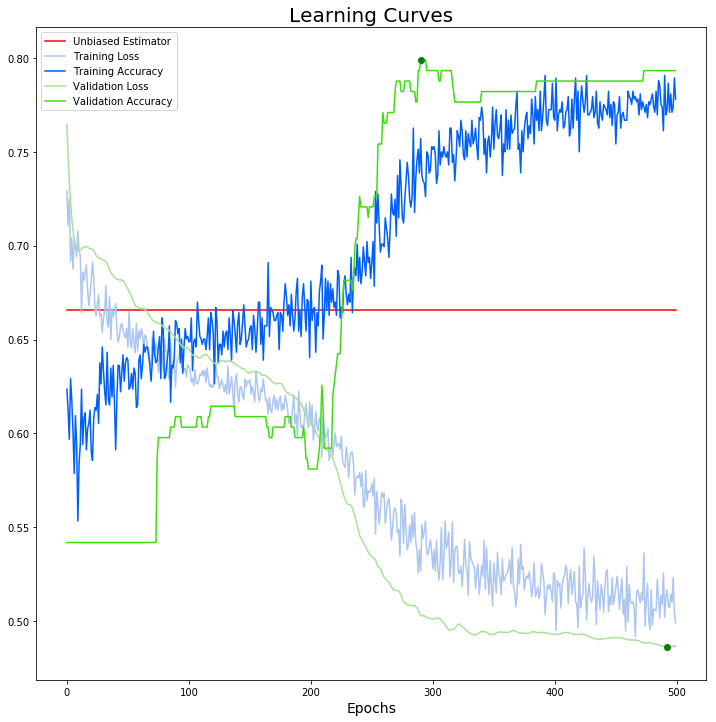

Max validation accuracy: 0.7988826632499695
Minimum validation loss: 0.4861399531364441
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           60          input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 30)           0           dense_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 31)           0           dropout_1[0][0]                  
                     

In [4]:
# Training Hyperparameters
batch_size = 300
epochs = 500

# Model Hyperparameters 
layerSize = 30
dropoutPercent = 0.5# Regularization 
lossFn = 'binary_crossentropy'
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


def makeModel(layerSize,dropoutPercent,lossFn,optimizer):
    inputs = []
    for i in range(train_x.shape[1]):
        inputs.append(Input(shape=(1,)))
    
    x = inputs[0]
    for i in range(train_x.shape[1]):
        x = Dense(layerSize, activation='sigmoid')(x)
        x = Dropout(dropoutPercent)(x)
        #x = BatchNormalization()(x)
        x = Concatenate()([x,inputs[i]])
        
    out = Dense(1,activation='sigmoid', name="output")(x)

    model = Model(inputs=inputs, outputs=out)
    model.compile(optimizer=optimizer,
                  loss=lossFn,
                  metrics=['acc'])
    
    return model

modelMain = makeModel(layerSize,dropoutPercent,lossFn,optimizer)

def spliceMat(mat):
    out = []
    for i in range(mat.shape[1]):
        out.append(mat[:,i])
    return out

hist = modelMain.fit(spliceMat(train_x), train_y,validation_data=(spliceMat(validation_x),validation_y), 
                     batch_size=batch_size,epochs=epochs, verbose=0)

def meanBaseline(df):
    nRows = df["Survived"].shape[0]
    mean = df["Survived"].sum()/nRows
    return log_loss(df["Survived"],np.full(nRows,mean))

def learningCurves(hist):
    histAcc_train = hist.history['acc']
    histLoss_train = hist.history['loss']
    histAcc_validation = hist.history['val_acc']
    histLoss_validation = hist.history['val_loss']
    maxValAcc = np.max(histAcc_validation)
    minValLoss = np.min(histLoss_validation)

    plt.figure(figsize=(12,12))

    plt.plot(range(epochs),np.full(epochs,meanBaseline(trainDF)),label="Unbiased Estimator", color="red")

    plt.plot(range(epochs),histLoss_train, label="Training Loss", color="#acc6ef")
    plt.plot(range(epochs),histAcc_train, label="Training Accuracy", color = "#005ff9" )

    plt.plot(range(epochs),histLoss_validation, label="Validation Loss", color="#a7e295")
    plt.plot(range(epochs),histAcc_validation, label="Validation Accuracy",color="#3ddd0d")

    plt.scatter(np.argmax(histAcc_validation),maxValAcc,zorder=10,color="green")
    plt.scatter(np.argmin(histLoss_validation),minValLoss,zorder=10,color="green")

    plt.xlabel('Epochs',fontsize=14)
    plt.title("Learning Curves",fontsize=20)

    plt.legend()
    plt.show()

    print("Max validation accuracy: {0}".format(maxValAcc))
    print("Minimum validation loss: {0}".format(minValLoss))

learningCurves(hist)
modelMain.summary()

In [6]:
 # Cross-Validation Parameter 
kFolds = 40

kfold = StratifiedKFold(n_splits=kFolds, shuffle=True)
means = []
stds = []
lossesLs = []
accuracyLs = []

runningLoss = []
runningAccuracy = []

# Train on k-folds of the data. 
for train, test in kfold.split(X, y):
    
    # Create new instance of our model. 
    model = makeModel(layerSize,dropoutPercent,lossFn,optimizer)
    
    # Train the model on this kfold. 
    model.fit(spliceMat(X[train]), y[train],batch_size=batch_size,epochs=epochs, verbose=0)

    # Evaluate the model
    loss,acc = model.evaluate(spliceMat(X[test]), y[test], verbose=0)
    
    # Log Cross-Validation Data
    lossesLs.append(loss)
    accuracyLs.append(acc)
    mean = np.mean(lossesLs)
    std = np.std(lossesLs)
    
    accuracyMean = np.mean(accuracyLs)
    accuracyStd = np.std(accuracyLs)
    
    runningLoss.append(mean)
    runningAccuracy.append(accuracyMean)
    
    print("Loss: %.2f%% (+/- %.2f%%) | Accuracy: %.2f%% (+/- %.2f%%)" % (mean*100,std,accuracyMean*100,accuracyStd))

plt.show()

Loss: 48.07% (+/- 0.00%) | Accuracy: 82.61% (+/- 0.00%)
Loss: 41.71% (+/- 0.06%) | Accuracy: 86.96% (+/- 0.04%)
Loss: 48.18% (+/- 0.11%) | Accuracy: 82.61% (+/- 0.07%)
Loss: 46.69% (+/- 0.09%) | Accuracy: 81.52% (+/- 0.06%)
Loss: 50.17% (+/- 0.11%) | Accuracy: 78.26% (+/- 0.09%)
Loss: 51.94% (+/- 0.11%) | Accuracy: 77.54% (+/- 0.08%)
Loss: 52.63% (+/- 0.10%) | Accuracy: 76.40% (+/- 0.08%)
Loss: 51.31% (+/- 0.10%) | Accuracy: 77.17% (+/- 0.08%)
Loss: 51.37% (+/- 0.10%) | Accuracy: 77.29% (+/- 0.07%)
Loss: 49.87% (+/- 0.10%) | Accuracy: 77.83% (+/- 0.07%)
Loss: 50.87% (+/- 0.10%) | Accuracy: 77.47% (+/- 0.07%)
Loss: 49.87% (+/- 0.10%) | Accuracy: 77.90% (+/- 0.07%)
Loss: 48.63% (+/- 0.11%) | Accuracy: 78.60% (+/- 0.07%)
Loss: 48.43% (+/- 0.10%) | Accuracy: 79.19% (+/- 0.07%)
Loss: 48.32% (+/- 0.10%) | Accuracy: 79.42% (+/- 0.07%)
Loss: 48.37% (+/- 0.10%) | Accuracy: 79.08% (+/- 0.07%)
Loss: 48.37% (+/- 0.09%) | Accuracy: 79.28% (+/- 0.07%)
Loss: 48.95% (+/- 0.09%) | Accuracy: 78.74% (+/-

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
plot_model(modelMain, to_file='model.png')


ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [5]:
pred = modelMain.predict(spliceMat(np.stack(testDF.apply(preprocessRow,axis=1))))
    
# The thrshold function which assigns a class of 0 or 1 based on the sigmoid output of the network. 
def thresholdFn(x):
    if(x < 0.5):
        return 0
    else:
        return 1
    
# Save the predictions to a CSV file in the format suitable for the competition. 
data_to_submit = pd.DataFrame.from_items([
    ('PassengerId',testDF["PassengerId"]),
    ('Survived', pd.Series(np.hstack(pred)).map(thresholdFn))])

data_to_submit.to_csv('neural11.csv', index = False)

In [ ]:
from sys import path
import os

In [ ]:
path.append("C:/Users/Andre/Anaconda3/envs/RefreshEnv/Library/bin/")

In [ ]:
os.environ["PATH"]+= os.pathsep + "C:/Users/Andre/Anaconda3/envs/RefreshEnv/Library/bin/graphviz/"

In [37]:
os.environ["PATH"]

'C:\\Users\\Andre\\Anaconda3\\envs\\RefreshEnv;C:\\Users\\Andre\\Anaconda3\\envs\\RefreshEnv\\Library\\mingw-w64\\bin;C:\\Users\\Andre\\Anaconda3\\envs\\RefreshEnv\\Library\\usr\\bin;C:\\Users\\Andre\\Anaconda3\\envs\\RefreshEnv\\Library\\bin;C:\\Users\\Andre\\Anaconda3\\envs\\RefreshEnv\\Scripts;C:\\Users\\Andre\\Anaconda3\\envs\\RefreshEnv\\bin;C:\\Users\\Andre\\Anaconda3;C:\\Users\\Andre\\Anaconda3\\Library\\mingw-w64\\bin;C:\\Users\\Andre\\Anaconda3\\Library\\usr\\bin;C:\\Users\\Andre\\Anaconda3\\Library\\bin;C:\\Users\\Andre\\Anaconda3\\Scripts;C:\\Users\\Andre\\Anaconda3\\Library\\bin;C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v9.0\\bin;C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v9.0\\libnvvp;C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v9.1\\bin;C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v9.1\\libnvvp;C:\\Program Files\\Docker\\Docker\\Resources\\bin;C:\\Program Files\\Haskell\\bin;C:\\Program Files\\Haskell Platform\\8.2.2\\lib\\ext

In [39]:
os.path

<module 'ntpath' from 'C:\\Users\\Andre\\Anaconda3\\envs\\RefreshEnv\\lib\\ntpath.py'>